In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

###Problema 1.

Output()

Output()

ERROR:pymc.stats.convergence:There were 288 divergences after tuning. Increase `target_accept` or reparameterize.



Intercept (alpha): -11.47
Panta (beta): 3.46
Frontiera de decizie: 3.45

Probabilitatile pentru fiecare valoare de intrare:
Ore studiate: 1, Probabilitate de promovare: 0.03
Ore studiate: 3, Probabilitate de promovare: 0.34
Ore studiate: 4, Probabilitate de promovare: 0.80
Ore studiate: 5, Probabilitate de promovare: 0.96
Ore studiate: 6, Probabilitate de promovare: 0.99
Ore studiate: 8, Probabilitate de promovare: 1.00


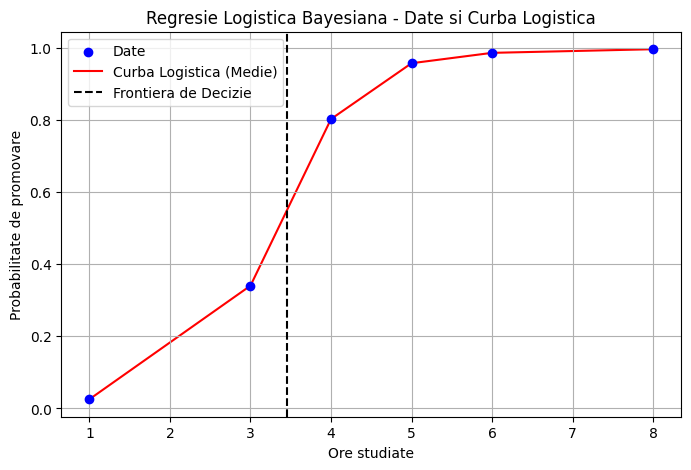

In [ ]:
# a)

hours_studied = np.array([1, 3, 4, 5, 6, 8])
promotion = np.array([0, 0, 1, 1, 1, 1])

with pm.Model() as logistic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10) # Intercept
    beta = pm.Normal("beta", mu=0, sigma=10) # Panta

    # Functia logistica
    mu = alpha + beta * hours_studied
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    # Verosimilitate
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=promotion)

    # Frontiera de decizie
    boundary = pm.Deterministic("boundary", -alpha / beta)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

alpha_mean = trace.posterior["alpha"].mean().item()
beta_mean = trace.posterior["beta"].mean().item()
boundary_mean = trace.posterior["boundary"].mean().item()
print(f"\nIntercept (alpha): {alpha_mean:.2f}")
print(f"Panta (beta): {beta_mean:.2f}")
print(f"Frontiera de decizie: {boundary_mean:.2f}")

theta_mean = trace.posterior["theta"].mean(dim=("chain", "draw")).values.flatten()
print("\nProbabilitatile pentru fiecare valoare de intrare:")
for i, (h, p) in enumerate(zip(hours_studied, theta_mean)):
    print(f"Ore studiate: {h}, Probabilitate de promovare: {p:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(hours_studied, theta_mean, label="Date", color="blue", zorder=2)
plt.plot(hours_studied, theta_mean, color="red", label="Curba Logistica (Medie)", zorder=1)
plt.axvline(boundary_mean, color="black", linestyle="--", label="Frontiera de Decizie")
plt.xlabel("Ore studiate")
plt.ylabel("Probabilitate de promovare")
plt.title("Regresie Logistica Bayesiana")
plt.legend()
plt.grid()
plt.show()

HDI 94%: [2.04, 4.57]


<Figure size 800x500 with 0 Axes>

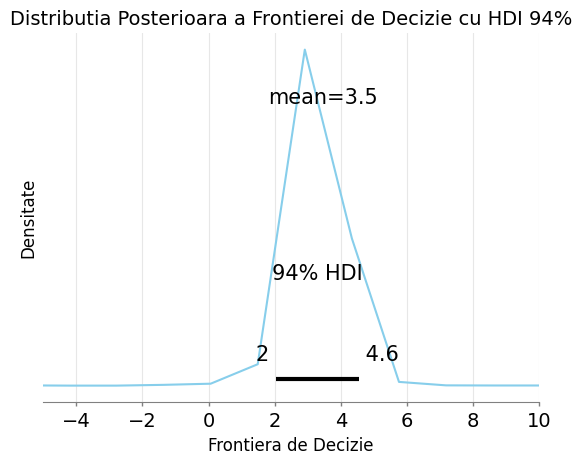

In [ ]:
# b)

boundary_samples = trace.posterior["boundary"].values.flatten()
boundary_hdi = az.hdi(boundary_samples, hdi_prob=0.94)

print(f"HDI 94%: [{boundary_hdi[0]:.2f}, {boundary_hdi[1]:.2f}]")

plt.figure(figsize=(8, 5))
az.plot_posterior(boundary_samples, hdi_prob=0.94, color="skyblue", kind="kde")

plt.title("Distributia Posterioara a Frontierei de Decizie cu HDI 94%", fontsize=14)
plt.xlabel("Frontiera de Decizie", fontsize=12)
plt.ylabel("Densitate", fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(-5, 10)
plt.show()

### Problema 2.

In [ ]:
# a)

file_path = '/content/Admission.csv'
data = pd.read_csv(file_path)

GRE = (data['GRE'] - data['GRE'].mean()) / data['GRE'].std()
GPA = (data['GPA'] - data['GPA'].mean()) / data['GPA'].std()
admission = data['Admission'].values

with pm.Model() as admission_model:
    # Distrib. a priori
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)  # Intercept
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)  # Coeficient pentru GRE
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)  # Coeficient pentru GPA

    # Functia logistica
    mu = beta_0 + beta_1 * GRE + beta_2 * GPA
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    # Verosimilitate
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=admission)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

beta_0_mean = trace.posterior["beta_0"].mean().item()
beta_1_mean = trace.posterior["beta_1"].mean().item()
beta_2_mean = trace.posterior["beta_2"].mean().item()

print(f"\nIntercept (beta_0): {beta_0_mean:.2f}")
print(f"Coeficient GRE (beta_1): {beta_1_mean:.2f}")
print(f"Coeficient GPA (beta_2): {beta_2_mean:.2f}\n")
print(az.summary(trace, var_names=["beta_0", "beta_1", "beta_2"]))

Output()

Output()


Intercept (beta_0): -0.82
Coeficient GRE (beta_1): 0.31
Coeficient GPA (beta_2): 0.29

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_0 -0.816  0.114  -1.022   -0.597      0.002    0.001    3575.0    2626.0   
beta_1  0.310  0.122   0.084    0.532      0.002    0.002    3283.0    2647.0   
beta_2  0.291  0.122   0.066    0.522      0.002    0.002    3195.0    2823.0   

        r_hat  
beta_0    1.0  
beta_1    1.0  
beta_2    1.0  


<ipython-input-6-efd6f30102d3>:35: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(decision_lines, hdi_prob=0.94)


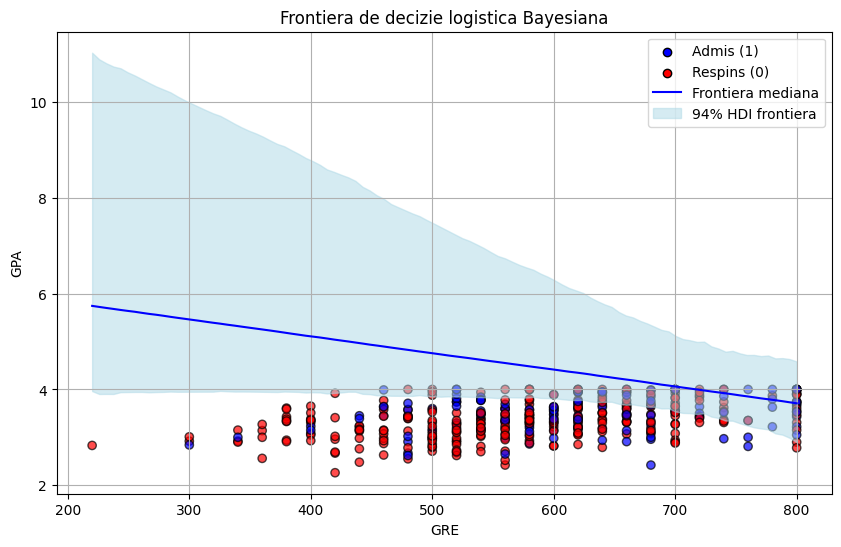

In [ ]:
# b)

# Valorile originale pentru standardizare inversa
GRE_mean, GRE_std = data['GRE'].mean(), data['GRE'].std()
GPA_mean, GPA_std = data['GPA'].mean(), data['GPA'].std()

# Parametrii posteriori din model
beta_0_samples = trace.posterior["beta_0"].values.flatten()
beta_1_samples = trace.posterior["beta_1"].values.flatten()
beta_2_samples = trace.posterior["beta_2"].values.flatten()

# Generam valori pentru GRE standardizat (pentru granita)
GRE_standard = np.linspace(GRE.min(), GRE.max(), 100)

# Calculam granita de decizie pe coord. standard. si inversam pentru GPA original
decision_lines = []
for beta_0, beta_1, beta_2 in zip(beta_0_samples, beta_1_samples, beta_2_samples):

    # Frontiera de decizie este data de p = 0.5 => mu = 0
    # => beta_0 + beta_1 * GRE_standard + beta_2 * GPA_standard = 0
    # => GPA_standard = -(beta_0 + beta_1 * GRE_standard) / beta_2
    GPA_standard = -(beta_0 + beta_1 * GRE_standard) / beta_2

    # Transf. GPA în coord. originale
    GPA_original = GPA_standard * GPA_std + GPA_mean
    decision_lines.append(GPA_original)

decision_lines = np.array(decision_lines)

# Transf. GRE în coord. originale
GRE_original = GRE_standard * GRE_std + GRE_mean

# Calculam mediana si intervalul HDI de 94%
mean_decision_boundary = np.median(decision_lines, axis=0)
hdi = az.hdi(decision_lines, hdi_prob=0.94)

# Grafic
plt.figure(figsize=(10, 6))
plt.scatter(data['GRE'], data['GPA'], c=1-admission, cmap="bwr", alpha=0.7, edgecolor="k")
plt.scatter([], [], color='blue', label='Admis (1)', edgecolor="k")
plt.scatter([], [], color='red', label='Respins (0)', edgecolor="k")
plt.plot(GRE_original, mean_decision_boundary, color='blue', label="Frontiera mediana")
plt.fill_between(GRE_original, hdi[:, 0], hdi[:, 1], color='lightblue', alpha=0.5, label="94% HDI frontiera")

plt.xlabel("GRE")
plt.ylabel("GPA")
plt.title("Frontiera de decizie logistica Bayesiana")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# c)

GRE_stud1 = 550
GPA_stud1 = 3.5

GRE_stud1_standard = (GRE_stud1 - GRE_mean) / GRE_std
GPA_stud1_standard = (GPA_stud1 - GPA_mean) / GPA_std

p_admission_samples = []
for beta_0, beta_1, beta_2 in zip(beta_0_samples, beta_1_samples, beta_2_samples):
    logit_p = beta_0 + beta_1 * GRE_stud1_standard + beta_2 * GPA_stud1_standard
    p = 1 / (1 + np.exp(-logit_p))
    p_admission_samples.append(p)

p_admission_samples = np.array(p_admission_samples)
hdi_90 = az.hdi(p_admission_samples, hdi_prob=0.90)

p_median = np.median(p_admission_samples)

print(f"Probabilitatea mediana ca studentul 1 sa fie admis: {p_median:.2f}")
print(f"Intervalul HDI de 90%: [{hdi_90[0]:.4f}, {hdi_90[1]:.4f}]")

Probabilitatea mediana ca studentul 1 sa fie admis: 0.30
Intervalul HDI de 90%: [0.2590, 0.3489]


In [ ]:
# d)

GRE_stud2 = 500
GPA_stud2 = 3.2

GRE_stud2_standard = (GRE_stud2 - GRE_mean) / GRE_std
GPA_stud2_standard = (GPA_stud2 - GPA_mean) / GPA_std

p_admission_samples = []
for beta_0, beta_1, beta_2 in zip(beta_0_samples, beta_1_samples, beta_2_samples):
    logit_p = beta_0 + beta_1 * GRE_stud2_standard + beta_2 * GPA_stud2_standard
    p = 1 / (1 + np.exp(-logit_p))
    p_admission_samples.append(p)

p_admission_samples = np.array(p_admission_samples)
hdi_90 = az.hdi(p_admission_samples, hdi_prob=0.90)

p_median = np.median(p_admission_samples)

print(f"Probabilitatea mediana ca studentul 2 sa fie admis: {p_median:.2f}")
print(f"Intervalul HDI de 90%: [{hdi_90[0]:.4f}, {hdi_90[1]:.4f}]\n")
print("""
=== Justificarea diferentei fata de cazul anterior ===
1. Valoarea mai mica a GRE (500 vs. 550) afecteaza negativ probabilitatea de admitere.
   - GRE are un coeficient pozitiv (beta_1), ceea ce inseamna ca o valoare mai mare creste sansele.
   - In acest caz, GRE mai mic duce la un logit mai mic, reducand probabilitatea.

2. Valoarea mai mica a GPA (3.2 vs. 3.5) contribuie suplimentar la scaderea probabilitatii.
   - GPA are si el un coeficient pozitiv (beta_2), astfel ca un GPA mai mic scade sansele.

3. Probabilitatea mediana este mai mica decat in cazul anterior, reflectand contributia cumulativa a scorurilor mai mici.
   - Intervalul HDI de 90% poate fi mai larg datorita incertitudinii crescute pentru aceste scoruri mai mici.

4. Modelul logistic penalizeaza ambele scaderi proportional cu importanta coeficientilor beta_1 si beta_2,
   ceea ce justifica rezultatul.
""")


Probabilitatea mediana ca studentul 2 sa fie admis: 0.23
Intervalul HDI de 90%: [0.1875, 0.2804]


=== Justificarea diferentei fata de cazul anterior ===
1. Valoarea mai mica a GRE (500 vs. 550) afecteaza negativ probabilitatea de admitere.
   - GRE are un coeficient pozitiv (beta_1), ceea ce inseamna ca o valoare mai mare creste sansele.
   - In acest caz, GRE mai mic duce la un logit mai mic, reducand probabilitatea.

2. Valoarea mai mica a GPA (3.2 vs. 3.5) contribuie suplimentar la scaderea probabilitatii.
   - GPA are si el un coeficient pozitiv (beta_2), astfel ca un GPA mai mic scade sansele.

3. Probabilitatea mediana este mai mica decat in cazul anterior, reflectand contributia cumulativa a scorurilor mai mici.
   - Intervalul HDI de 90% poate fi mai larg datorita incertitudinii crescute pentru aceste scoruri mai mici.

4. Modelul logistic penalizeaza ambele scaderi proportional cu importanta coeficientilor beta_1 si beta_2,
   ceea ce justifica rezultatul.

